In [89]:
import json
import os.path as op
from os import sep
from utilities import files
import nibabel as nb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib_surface_plotting import plot_surf
from mne import read_epochs, pick_types
import scipy.ndimage as ndimage
from scipy.interpolate import interp2d, interp1d
from matplotlib import cm
from scipy.signal import savgol_filter
from itertools import permutations

In [4]:
subj_idx=0
session_idxs=[0]
epo_type='motor'

# opening a json file
json_file="settings.json"
with open(json_file) as pipeline_file:
        parameters = json.load(pipeline_file)
        
if 'motor' in epo_type:
    # From BigBrain sample M1 location
    layer1_thickness=0.237 # mm
    layer23_thickness=0.926 # mm
    layer4_thickness=0
    layer5_thickness=0.763 # mm
    layer6_thickness=0.867 # mm
    total_thickness=layer1_thickness+layer23_thickness+layer4_thickness+layer5_thickness+layer6_thickness
    layer1_rel_thickness=layer1_thickness/total_thickness
    layer23_rel_thickness=layer23_thickness/total_thickness
    layer4_rel_thickness=layer4_thickness/total_thickness
    layer5_rel_thickness=layer5_thickness/total_thickness
    layer6_rel_thickness=layer6_thickness/total_thickness
elif 'visual' in epo_type:
    layer1_thickness=0.163 # mm
    layer23_thickness=0.702 # mm
    layer4_thickness=0.135 # mm
    layer5_thickness=0.562 # mm
    layer6_thickness=0.822 # mm
    total_thickness=layer1_thickness+layer23_thickness+layer4_thickness+layer5_thickness+layer6_thickness
    layer1_rel_thickness=layer1_thickness/total_thickness
    layer23_rel_thickness=layer23_thickness/total_thickness
    layer4_rel_thickness=layer4_thickness/total_thickness
    layer5_rel_thickness=layer5_thickness/total_thickness
    layer6_rel_thickness=layer6_thickness/total_thickness

In [5]:
path = parameters["dataset_path"]
der_path = op.join(path, "derivatives")
proc_path = op.join(der_path, "processed")

subjects = files.get_folders_files(proc_path)[0]
subjects.sort()

subject = subjects[subj_idx]
subject_id = subject.split("/")[-1]

sessions = files.get_folders(subject, 'ses', '')[2]
sessions.sort()

n_surfs=11

print("ID:", subject_id)
print("Epoch:", epo_type)

ID: sub-001
Epoch: motor


In [149]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [140]:
def plot_csd(csd, times, n_surfs, ax, vmin=None, vmax=None, plot_boundaries=True):
    if vmin is None:
        vmin=np.min(csd[:])
    if vmax is None:
        vmax=np.max(csd[:])
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    levels=np.linspace(vmin,vmax,100)
    im=ax.contourf(csd,cmap='RdBu_r', levels=levels, vmin=vmin, vmax=vmax,
             extent=[times[0], times[-1], 0, n_surfs-1], origin='lower', norm=divnorm, extend='both')
    yticks=ax.get_yticks()
    ax.set_yticks(range(n_surfs,-1,-1))
    ax.set_ylim([n_surfs-1,0])
    
    if plot_boundaries:
        layer1_boundary=(n_surfs-1)*layer1_rel_thickness
        ax.plot([times[0], times[-1]],[layer1_boundary, layer1_boundary],'k--')
        ax.text(times[-1]+.02, layer1_boundary, 'I')

        layer23_boundary=layer1_boundary+(n_surfs-1)*layer23_rel_thickness
        ax.plot([times[0], times[-1]],[layer23_boundary, layer23_boundary],'k--')
        ax.text(times[-1]+.02, layer1_boundary+.5*(layer23_boundary-layer1_boundary), 'II/III')

        layer4_boundary=layer23_boundary+(n_surfs-1)*layer4_rel_thickness
        if layer4_rel_thickness>0:
            ax.plot([times[0], times[-1]],[layer4_boundary, layer4_boundary],'k--')
            ax.text(times[-1]+.02, layer23_boundary+.5*(layer4_boundary-layer23_boundary), 'IV')

        layer5_boundary=layer4_boundary+(n_surfs-1)*layer5_rel_thickness
        ax.plot([times[0], times[-1]],[layer5_boundary, layer5_boundary],'k--')
        ax.text(times[-1]+.02, layer4_boundary+.5*(layer5_boundary-layer4_boundary), 'V')

        layer6_boundary=layer5_boundary+(n_surfs-1)*layer6_rel_thickness
        ax.text(times[-1]+.02, layer5_boundary+.5*(layer6_boundary-layer5_boundary), 'VI')
    
    ax.plot([0, 0], [0,10],'--',color='grey')
    ax.set_xlim([times[0], times[-1]])
    for yidx,ytick in enumerate(ax.get_yticklabels()):
        ytick.set_color(cool_colors[yidx-1])
    ax.set_ylabel('surface')
    ax.set_xlabel('time (s)')
    cb=plt.colorbar(im, ax=ax, pad=0.1)
#     cb.set_ticks([])

In [150]:
session_idx=0
session=sessions[session_idx]
session_id = session.split("/")[-1]

res_fnames = files.get_files(op.join(session, 'spm'), "invert_fmspm_converted_autoreject", epo_type + "-epo_multilayer_results.json")[2]
res_fnames.sort()
print("Session:", session_id)

run_idx=0
res_fname=res_fnames[run_idx]

numero = res_fname.split(sep)[-1].split("-")[5]

with open(res_fname) as results_file:
    results = json.load(results_file)

print("Run:", numero)

# Load multilayer surface
multilayer_surf=nb.load(results['surf_fname']);
multilayer_vertices, multilayer_faces = multilayer_surf.darrays[0].data, multilayer_surf.darrays[1].data

# Load pial surface
pial_surf_fname = op.join(sep.join(results['surf_fname'].split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
pial_surf=nb.load(pial_surf_fname);
pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data

# Load inversion results and MU matrix
res = pd.read_csv(results['res_fname'], sep="\t", header=None).values
MU=pd.read_csv(results['mu_fname'], sep="\t", header=None).values

n_vertices_per_surf=int(res.shape[0]/n_surfs)

# Average over surfaces
surf_averaged=np.zeros(n_vertices_per_surf)
for i in range(n_surfs):
    surf_averaged=surf_averaged+res[i*n_vertices_per_surf:(i+1)*n_vertices_per_surf,0]
surf_averaged=surf_averaged/n_surfs

# Get the peak index
peak_idx=np.argmax(surf_averaged)

# Check surface spacing
peak_coord=np.zeros((n_surfs,3))
for i in range(n_surfs):
    peak_coord[i,:]=multilayer_vertices[i*n_vertices_per_surf+peak_idx,:]
print('Pial coord={}'.format(peak_coord[-1,:]))
dists=np.sqrt(np.sum((peak_coord[1:,:]-peak_coord[0:-1,:])**2,axis=1))
print('Inter-surface distances={}'.format(dists))
mean_dist=np.mean(dists)
print('Mean distance={}'.format(mean_dist))

# Load data
epo_path = op.join(session, 'autoreject-' + subject_id + "-" + session_id + "-" + numero + "-" + epo_type + "-epo.fif")
epochs = read_epochs(epo_path, verbose=False, preload=True)
#epochs = epochs.filter(0,30)
meg_chans=pick_types(epochs.info,meg=True, ref_meg=False)
epo_data=epochs.get_data()
epo_data=epo_data[:,meg_chans,:]

# Average over trials
evoked=np.mean(epo_data,axis=0)
# Get source time course in each surface
surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
for i in range(n_surfs):
    surf_peak_idx=i*n_vertices_per_surf+peak_idx
    surf_tcs[n_surfs-i-1,:]=np.matmul(MU[surf_peak_idx,:].reshape(1,-1),evoked)
    
csd=compute_csd(surf_tcs, epochs.times, mean_dist, n_surfs)
csd_smooth=smooth_csd(csd, n_surfs)

Session: ses-01
Run: 001
Pial coord=[-23.66276932   6.82642794  47.30088425]
Inter-surface distances=[0.24964542 0.24963102 0.24967808 0.24966206 0.24965759 0.24965985
 0.24965759 0.24966057 0.24965759 0.24966609]
Mean distance=0.24965758668182433


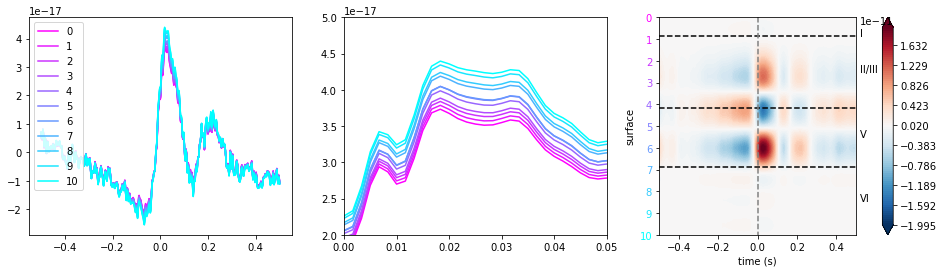

In [151]:
cool_colors = plt.cm.cool(np.linspace(0,1,n_surfs))

plt.figure(figsize=(16,4),facecolor='white')
ax=plt.subplot(1,3,1)
for i in range(n_surfs):
    ax.plot(epochs.times,surf_tcs[i,:],color=cool_colors[n_surfs-i-1], label='{}'.format(i))
plt.legend(loc='upper left')

ax=plt.subplot(1,3,2)
for i in range(n_surfs):
    plt.plot(epochs.times,surf_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.xlim([0,.05])
plt.ylim([2e-17, 5e-17])

ax = plt.subplot(1, 3, 3)
vmin=-np.max(np.abs(csd_smooth[:]))
vmax=np.max(np.abs(csd_smooth[:]))
plot_csd(csd_smooth, epochs.times, n_surfs, ax, plot_boundaries=True, vmin=vmin, vmax=vmax)

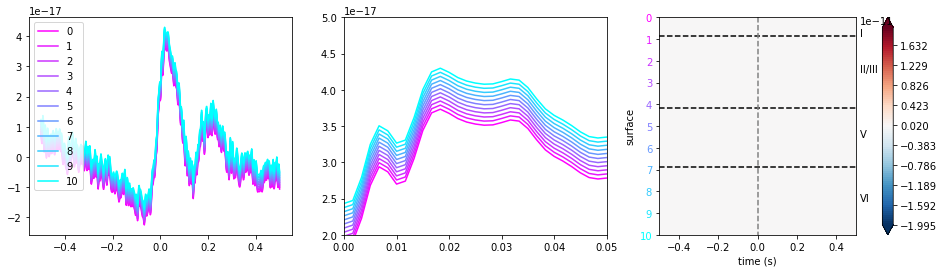

In [156]:
sim_base=surf_tcs[0,:]
offset=np.mean(surf_tcs[1,310:320]-surf_tcs[0,310:320])
sim_surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
for i in range(n_surfs):
    sim_surf_tcs[i,:]=sim_base+i*offset
    
    
csd=compute_csd(sim_surf_tcs, epochs.times, mean_dist, n_surfs)
csd_smooth=smooth_csd(csd, n_surfs)

cool_colors = plt.cm.cool(np.linspace(0,1,n_surfs))
plt.figure(figsize=(16,4),facecolor='white')

ax=plt.subplot(1,3,1)
for i in range(n_surfs):
    ax.plot(epochs.times,sim_surf_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.legend(loc='upper left')

ax=plt.subplot(1,3,2)
for i in range(n_surfs):
    plt.plot(epochs.times,sim_surf_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.xlim([0,.05])
plt.ylim([2e-17, 5e-17])

ax = plt.subplot(1, 3, 3)
plot_csd(csd_smooth, epochs.times, n_surfs, ax, plot_boundaries=True, vmin=vmin, vmax=vmax)


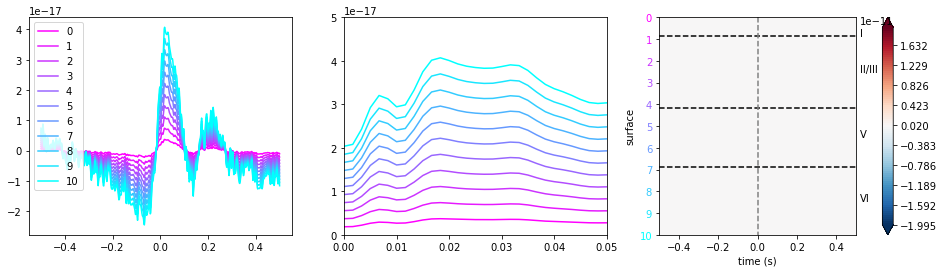

In [158]:
sim_base=surf_tcs[0,:]
factor=np.mean(np.mean(surf_tcs[1:-1,310:320]/sim_base[310:320],axis=1),axis=0)/n_surfs
sim_surf_tcs=np.zeros((n_surfs, evoked.shape[1]))
for i in range(n_surfs):    
    sim_surf_tcs[i,:]=sim_base*(i+1)*factor
    
csd=compute_csd(sim_surf_tcs, epochs.times, mean_dist, n_surfs)
csd_smooth=smooth_csd(csd, n_surfs)

cool_colors = plt.cm.cool(np.linspace(0,1,n_surfs))
plt.figure(figsize=(16,4),facecolor='white')

ax=plt.subplot(1,3,1)
for i in range(n_surfs):
    ax.plot(epochs.times,sim_surf_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.legend(loc='upper left')

ax=plt.subplot(1,3,2)
for i in range(n_surfs):
    plt.plot(epochs.times,sim_surf_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.xlim([0,.05])
plt.ylim([0, 5e-17])

ax = plt.subplot(1, 3, 3)
plot_csd(csd_smooth, epochs.times, n_surfs, ax, plot_boundaries=True, vmin=vmin, vmax=vmax)

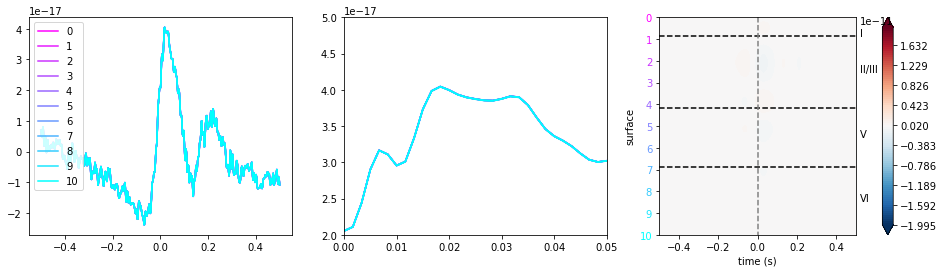

In [154]:
n_shuffs=10000
shuff_csds=[]
shuff_tcs=[]
for i in range(n_shuffs):
    sim_surf_tcs=np.random.permutation(surf_tcs)
    shuff_tcs.append(sim_surf_tcs)
    csd=compute_csd(sim_surf_tcs, epochs.times, mean_dist, n_surfs)
    csd_smooth=smooth_csd(csd, n_surfs)
    shuff_csds.append(csd_smooth)
shuff_tcs=np.mean(np.array(shuff_tcs),axis=0)    
shuff_csds=np.mean(np.array(shuff_csds),axis=0)

plt.figure(figsize=(16,4),facecolor='white')

ax=plt.subplot(1,3,1)
for i in range(n_surfs):
    ax.plot(epochs.times,shuff_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.legend(loc='upper left')

ax=plt.subplot(1,3,2)
for i in range(n_surfs):
    plt.plot(epochs.times,shuff_tcs[i,:],color=cool_colors[n_surfs-i-1],label='{}'.format(i))
plt.xlim([0,.05])
plt.ylim([2e-17, 5e-17])

ax = plt.subplot(1, 3, 3)
plot_csd(shuff_csds, epochs.times, n_surfs, ax, plot_boundaries=True, vmin=vmin, vmax=vmax)